<a href="https://colab.research.google.com/github/DjordjeSevic/PPPO_boat_detection/blob/main/IT34_2019_boat_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predmet:** Principi prezentacije i prepoznavanja oblika

**Student:** Đorđe Šević IT 34-2019

**Tema:** Detekcija broda

**Detekcija objekata** u kontekstu mašinskog učenja je proces identifikacije i lokalizacije određenih objekata unutar digitalne slike ili videa. Ova tehnika se često koristi u autonomnim vozilima, sigurnosnim sistemima, medicinskim aplikacijama i mnogim drugim oblastima.
U biti predstavlja tehniku računarske vizije (engl. *computer vision*).

Glavni cilj detekcije objekata je pronaći prisustvo određenih klasa objekata (npr. ljude, automobile, životinje, **a u kontekstu ovog projekta brodove**) u slikama i videima, kao i pružiti informacije o njihovoj tačnoj lokaciji unutar slike ili videa. Ovaj proces obično uključuje nekoliko koraka:

1. **Ekstrakcija karakteristika** (engl. *feature extraction*): Ulazna slika se obrađuje kako bi se izdvojile relevantne karakteristike koje se koriste za identifikaciju objekata. Ovo može uključivati korišćenje tehnika kao što su histogram orijentisanih gradijenata (HOG), karakterističke tačke (npr. SIFT, SURF), ili duboke konvolucione neuronske mreže (CNN). U ovom projektu biće korišćena Mask R-CNN (engl. *Mask Region-based Convolutional Neural Network*).

2. **Detekcija objekata:** Nakon ekstrakcije karakteristika, model se koristi za identifikaciju prisustva objekata u slici/videu i određivanje njihovih lokacija. Ovo se obično postiže korišćenjem različitih tehnika, kao što su modeli na osnovu regija (engl. *Region-based models*) ili mreže za detekciju objekata (engl. *Object detection networks*), kao što su Faster R-CNN, YOLO (engl. *You Only Look Once*), SSD (engl. *Single Shot MultiBox Detector*) i druge.

3. **Klasifikacija objekata:** Nakon što su objekti detektovani, često se vrši klasifikacija, tj. dodeljivanje identiteta ili klase svakom detektovanom objektu. Ovo se obično postiže korišćenjem klasifikacionih modela koji su obučeni za prepoznavanje različitih klasa objekata.

4. **Postprocesiranje:** Konačni korak uključuje postprocesiranje rezultata kako bi se poboljšala tačnost i preciznost detekcije, kao što su odbacivanje duplih detekcija, spajanje susednih detekcija i slično.

Detekcija objekata je ključni deo mnogih aplikacija veštačke inteligencije i računarske vizije, omogućavajući računarima da automatski prepoznaju i razumeju sadržaj slika i videa, što ih čini veoma korisnim alatom u mnogim industrijama i oblastima istraživanja.

Primer detekcije objekata prikazan je na slici:

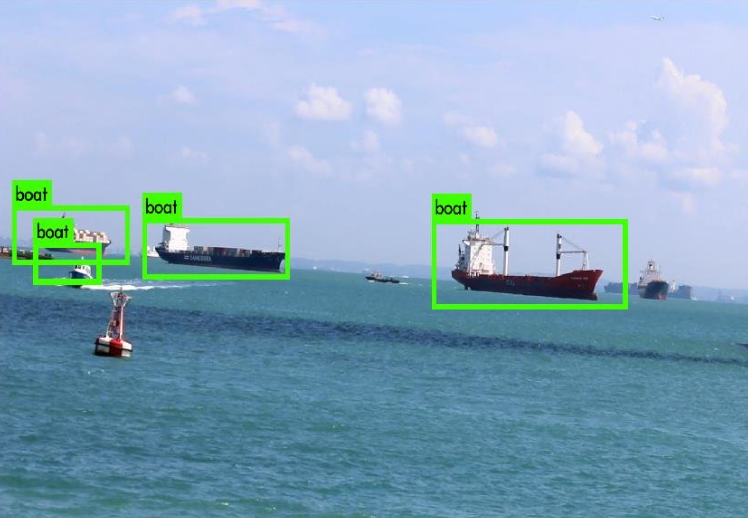








**PROJEKTNI ZADATAK I SET PODATAKA KORIŠĆEN U PROJEKTU**

Cilj projekta je, kao što je već rečeno, razvoj modela za detekciju i klasifikaciju brodova na slikama iz seta podataka. Slike su snimljene iz ptičije perspektive, a na slike za trening su označene kao one sa ili bez prisustva brodova, kao i tim da li je jedan ili više brodova na slici ukoliko je brod/brodovi su detektovani.

Dostupni set podataka se sastoji iz sledećih datoteka:
1. **train_v2** - Folder koji sadrži slike namenjene treniranju modela.
2.**test_v2**- Folder koji sadrži slike namenjene testiranju modela.
3. **train_ship_segmentatons_v2.csv** - Fajl koji sadrži podatke za obuku.
4. **sample_submission_v2.csv** - Format fajla koji se očekuje kao krajnji ishod zadatka.

<h2>Pristup skupu podataka i instalacija neophodnih resursa</h2>

Shodno veličini skupa podataka nad kojim se realizuje projektni zadatak, najadekvatnije je njemu pristupiti preko Google Drive-a i tu ga raspakovati kroz komande koje će biti u daljem delu projekta navedene

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Python packet manager i instalcija gdown biblioteke koja je potrebna za pristup datotekama sa GDrive-a u Colab

In [ ]:
!pip install gdown

In [ ]:
import gdown

In [ ]:
import os
import sys
import random
import math
import warnings
import numpy as np
import cv2

In [ ]:
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd
import glob
import numpy as np
import pandas as pd
from skimage.io import imread

In [ ]:
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable()

Kao što je rečeno na početku, za izradu projekta koristi se Mask RCNN, te se u narednom koraku preuzima već postojeća biblioteka.

In [ ]:
!git clone https://github.com/maxw1489/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 6), reused 20 (delta 0), pack-reused 0
Receiving objects: 100% (31/31), 10.81 MiB | 4.25 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
sys.path.append(os.path.join('Mask_RCNN'))

In [ ]:
from mrcnn.config import Config

In [ ]:
from mrcnn import utils

In [ ]:
import mrcnn.model as modellib

In [ ]:
from mrcnn import visualize

In [ ]:
from mrcnn.model import log

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


Učitavanje seta u Colab:

In [ ]:
data_dir = '/content/drive/MyDrive/Ships_Detection'
main_dir = '/content/drive/MyDrive/'

In [ ]:
train_dir = os.path.join(data_dir, 'train_v2')
test_dir = os.path.join(data_dir, 'test_v2')

Analiziranje seta podataka

In [ ]:
import os

train_images = os.listdir(train_dir)
num_train_images = len(train_images)

test_images = os.listdir(test_dir)
num_test_images = len(test_images)

In [ ]:
# slike za obuku
print(num_train_images)

# slike za testiranje
print(num_test_images)

44768
6882


In [ ]:
import pandas as pd
import os

In [ ]:
csv_file1 = os.path.join('/content/drive/MyDrive/Ships_Detection/', 'sample_submission_v2.csv')
csv_file2 = os.path.join('/content/drive/MyDrive/Ships_Detection/', 'train_ship_segmentations_v2.csv')

In [ ]:
df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)

# DataFrame

print("\nsample_submission_v2.csv:")
print(df1)

print("\ntrain_ship_segmentations_v2.csv:")
print(df2)


sample_submission_v2.csv:
             ImageId EncodedPixels
0      00002bd58.jpg           1 2
1      00015efb6.jpg           1 2
2      00023d5fc.jpg           1 2
3      000367c13.jpg           1 2
4      0008ca6e9.jpg           1 2
...              ...           ...
15601  ffdb3cda6.jpg           1 2
15602  ffe3857eb.jpg           1 2
15603  ffeb765e8.jpg           1 2
15604  ffeba1475.jpg           1 2
15605  fff0fd44f.jpg           1 2

[15606 rows x 2 columns]

train_ship_segmentations_v2.csv:
             ImageId                                      EncodedPixels
0      000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
1      000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
2      000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3      000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
4      000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...              ...                                         

In [ ]:
import pandas as pd

# Učitavanje CSV fajla sa podacima o treningu
train_csv = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v2.csv'
df_train = pd.read_csv(train_csv)

In [ ]:
# Raspodela klasa
class_counts = df_train['EncodedPixels'].notnull().value_counts()

print("Raspodela klasa:")
print(class_counts)

Raspodela klasa:
False    23396
True     12639
Name: EncodedPixels, dtype: int64


Komanda za rad sa slikama koja omogućuje prikaz slike iz seta.

In [ ]:
from PIL import Image


In [ ]:

from sklearn.model_selection import train_test_split
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg',
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

def filter_file_names(directory, exclude_list):
    file_names = []
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file() and entry.name not in exclude_list:
                file_names.append(entry.name)
    return file_names

train_names = filter_file_names(train_dir, exclude_list)
test_names = filter_file_names(test_dir, exclude_list)

 Postavljanjem debug na `False`, program se obično izvršava bez dodatnih izlaznih informacija ili poruka za debagovanje, čime se može poboljšati preglednost.

In [ ]:
debug = False

Kreiranje train i test names Data Frame-ova korišćenjem pandas biblioteke, koji se čuvaju na drajvu u CSV fajlu na zadatoj putanji.

Kreirani CSV fajlovi služe da daju uvid u imena slika za trening i test skup podataka, što će se koristiti kasnije u analizi i u okviru kreiranja modela.

In [ ]:
df = pd.DataFrame({'File Name': train_names})
df.to_csv('/content/drive/MyDrive/Ships_Detection/train_names.csv', index=False)

In [ ]:
df = pd.DataFrame({'File Name': test_names})
df.to_csv('/content/drive/MyDrive/Ships_Detection/test_names.csv', index=False)

In [ ]:
#print(train_names)

print(len(train_names), len(test_names))

44768 6882


Učitavanje prethodno generisanih CSV fajlova:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Ships_Detection/train_names.csv')

train_names1 = df['File Name']


df = pd.read_csv('/content/drive/MyDrive/Ships_Detection/test_names.csv')

test_names1 = df['File Name']


Filtriranje podataka o segmentaciji brodova na osnovu imena slika koje se nalaze u datom folderu sa slikama:

In [ ]:
image_folder = '/content/drive/MyDrive/Ships_Detection/train_v2'


csv_file = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v2.csv'

image_names = [os.path.splitext(filename)[0] + '.jpg' for filename in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, filename))]

data = pd.read_csv(csv_file)

filtered_data = data[data['ImageId'].isin(image_names)]

filtered_data.to_csv('/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v3.csv',index=False)

Učitavanje CSV datoteke train_ship_segmentations_v3.csv koja sadrži informacije o segmentacijama brodova za trening skup podataka:

In [ ]:
rle = '/content/drive/MyDrive/Ships_Detection/train_ship_segmentations_v3.csv'
annotations = pd.read_csv(rle)
annotations.shape

(36035, 2)

In [ ]:
im_names, image_annotations = train_names1, annotations


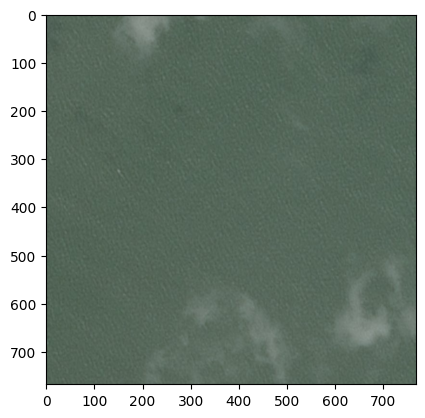

In [ ]:
ds = imread(os.path.join(train_dir, im_names[0]))
_ = plt.imshow(ds)


In [ ]:
ORIG_SIZE = 768


<h2>KREIRANJE MODELA ZA DETEKCIJU BRODOVA</h2>

In [ ]:
class ModelConfig(Config):

    NAME = 'Initial'
    GPU_COUNT = 1 #broj GPU koji će biti korišćeni za treniranje modela
    IMAGES_PER_GPU = 8 #broj slika koje će biti obrađene u svakoj od iteracija GPU-1

    BACKBONE = 'resnet50' #koristi se ResNet-50 kao osnovni model u arhitekturi

    NUM_CLASSES = 2 #broj klasa koje model treba da prepozna

    IMAGE_MIN_DIM = 384 #min i max dimenzija slika,
    IMAGE_MAX_DIM = 384 #a pre prosleđivanja modelu sve slike će biti promenjene

    TRAIN_ROIS_PER_IMAGE = 64 #broj regija interesa
    MAX_GT_INSTANCES = 2 #maks broj instanci po slici koji će se koristiti za treniranje
    DETECTION_MAX_INSTANCES = 15 #max broj detektovanih instanci po slici
    DETECTION_MIN_CONFIDENCE = 0.85 #min veruvatnoća za prihvatanje objekta kao detektovanog
    DETECTION_NMS_THRESHOLD = 0.0 #Prag za NMS (Non-Maximum Suppression) postupak koji se koristi za uklanjanje duplikata detekcija
    RUN_EAGERLY = False

    STEPS_PER_EPOCH = 15 if debug else 5 #broj iteracija za svaku epohu u okviru trenirnaja i validacije
    VALIDATION_STEPS = 10 if debug else 3

    #Rečnik koji sadrži težine različitih gubitaka koji će se koristiti tokom treniranja modela.
    #Ove težine mogu pomoći u prilagođavanju uticaja pojedinih gubitaka tokom optimizacije.
    #Ovo omogućava prilagodljivost u tome kako se različiti delovi modela tretiraju tokom treniranja,
    # što može biti korisno za postizanje boljih performansi ili boljeg prilagođavanja modela specifičnim potrebama ili zahtevima zadatka.

    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = ModelConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        15
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

Klasa `LoadDataset` nasleđuje od `utils.Dataset` i implementira metode za učitavanje slika, maski i informacija o anotacijama kako bi se kreirao skup podataka za treniranje modela detekcije brodova na osnovu slika i njihovih RLE (Run-Length Encoding) anotacija.

In [ ]:
class LoadDataset(utils.Dataset):

    def __init__(self, im_names, image_annotations, orig_height, orig_width):
        super().__init__(self)

        self.add_class('ship', 1, 'Ship')

        for i, fp in enumerate(im_names):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dir, fp),
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

Skup imena slika sa RLE anotacijama se podeljuje na trening i validacioni skup koristeći `train_test_split` funkciju, pri čemu se uzima u obzir veličina validacionog skupa definisana parametrima `config.VALIDATION_STEPS` i `config.IMAGES_PER_GPU`, a u slučaju debagovanja ograničava se na prvih 100 imena slika.

In [ ]:
from sklearn.model_selection import train_test_split
train_names1 = annotations[annotations.EncodedPixels.notnull()].ImageId.unique().tolist()  ## override with ships

test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU
im_names_train, im_names_val = train_test_split(train_names1, test_size=test_size, random_state=42)

if debug:
    im_names_train = im_names_train[:100]
    im_names_val = im_names_val[:100]
    test_names1 = test_names1[:100]

print(len(im_names_train), len(im_names_val), len(test_names1))

6538 24 6882


Ova ćelija koda koristi IPython komandu `%%time` kako bi merila vreme izvršavanja bloka koda koji sledi. Zatim se kreira instanca klase `LoadDataset` sa imenima slika za trening (`im_names_train`), informacijama o anotacijama (`image_annotations`) i originalnom veličinom slika (`ORIG_SIZE`). Nakon toga, poziva se metoda `prepare()` na instanci kako bi se pripremio dataset za treniranje modela. Vreme izvršavanja se meri i prikazuje u rezultatima izvršavanja.

In [ ]:
%%time
dataset_train = LoadDataset(im_names_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

CPU times: user 27 s, sys: 380 ms, total: 27.4 s
Wall time: 47.9 s


In [ ]:
%%time
dataset_val = LoadDataset(im_names_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

CPU times: user 88.9 ms, sys: 2.66 ms, total: 91.6 ms
Wall time: 100 ms


Ovde se kreira instanca modela `MaskRCNN` iz biblioteke `modellib`, sa režimom rada postavljenim na 'training', konfiguracijom definisanom prethodno u klasi `ModelConfig` (instanciranoj kao `config`), i direktorijumom za čuvanje modela postavljenim na `main_dir`.

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=main_dir)


Upozorenja su isključena kako bi se sprečilo prikazivanje upozorenja tokom izvršavanja koda.

In [ ]:
LEARNING_RATE = 0.003

import warnings
warnings.filterwarnings("ignore")

Model se trenira koristeći `train` metodu.


In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads')

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: /content/drive/MyDrive/initial20240122T2231/mask_rcnn_initial_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=2,
            layers='all')

new_history = model.keras_model.history.history


Starting at epoch 2. LR=0.003

Checkpoint Path: /content/drive/MyDrive/initial20240122T2231/mask_rcnn_initial_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2

In [ ]:
history

{'loss': [232.40365600585938, 226.4940643310547],
 'rpn_class_loss': [218.6803741455078, 217.330078125],
 'rpn_bbox_loss': [6.6458539962768555, 5.931121826171875],
 'mrcnn_class_loss': [3.4658641815185547, 0.2114497870206833],
 'mrcnn_bbox_loss': [2.8466646671295166, 2.8230528831481934],
 'mrcnn_mask_loss': [0.7649036049842834, 0.19836726784706116],
 'val_loss': [237.19244384765625, 125.51565551757812],
 'val_rpn_class_loss': [224.41766357421875, 118.73004150390625],
 'val_rpn_bbox_loss': [6.521931171417236, 5.181403636932373],
 'val_mrcnn_class_loss': [0.045310717076063156, 0.19823963940143585],
 'val_mrcnn_bbox_loss': [5.901521682739258, 1.0921128988265991],
 'val_mrcnn_mask_loss': [0.306020051240921, 0.31385716795921326]}

Korišćenjem pickle biblioteke omogućeno je čuvanje istorije treninga modela koja kasnije može da se analizira ili koristi za ponovno učitavanje u drugim sesijama izvršavanja koda.

In [ ]:
import pickle


In [ ]:
with open('/content/drive/MyDrive/Ships_Detection/history.pkl', 'wb') as file:
    pickle.dump(history, file)

Ovde se koristi biblioteka pandas (`pd`) za kreiranje DataFrame objekta koji sadrži informacije iz istorije treninga modela (`history`) sa indeksima epoha i prikazuje gubitke i metrike.

In [ ]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss
1,232.403656,218.680374,6.645854,3.465864,2.846665,0.764904,237.192444,224.417664,6.521931,0.045311,5.901522,0.306020
2,226.494064,217.330078,5.931122,0.211450,2.823053,0.198367,125.515656,118.730042,5.181404,0.198240,1.092113,0.313857


Ovde se koristi biblioteka matplotlib (plt) za prikazivanje grafika gubitaka i metrika tokom treninga i validacije kroz različite epohe modela.

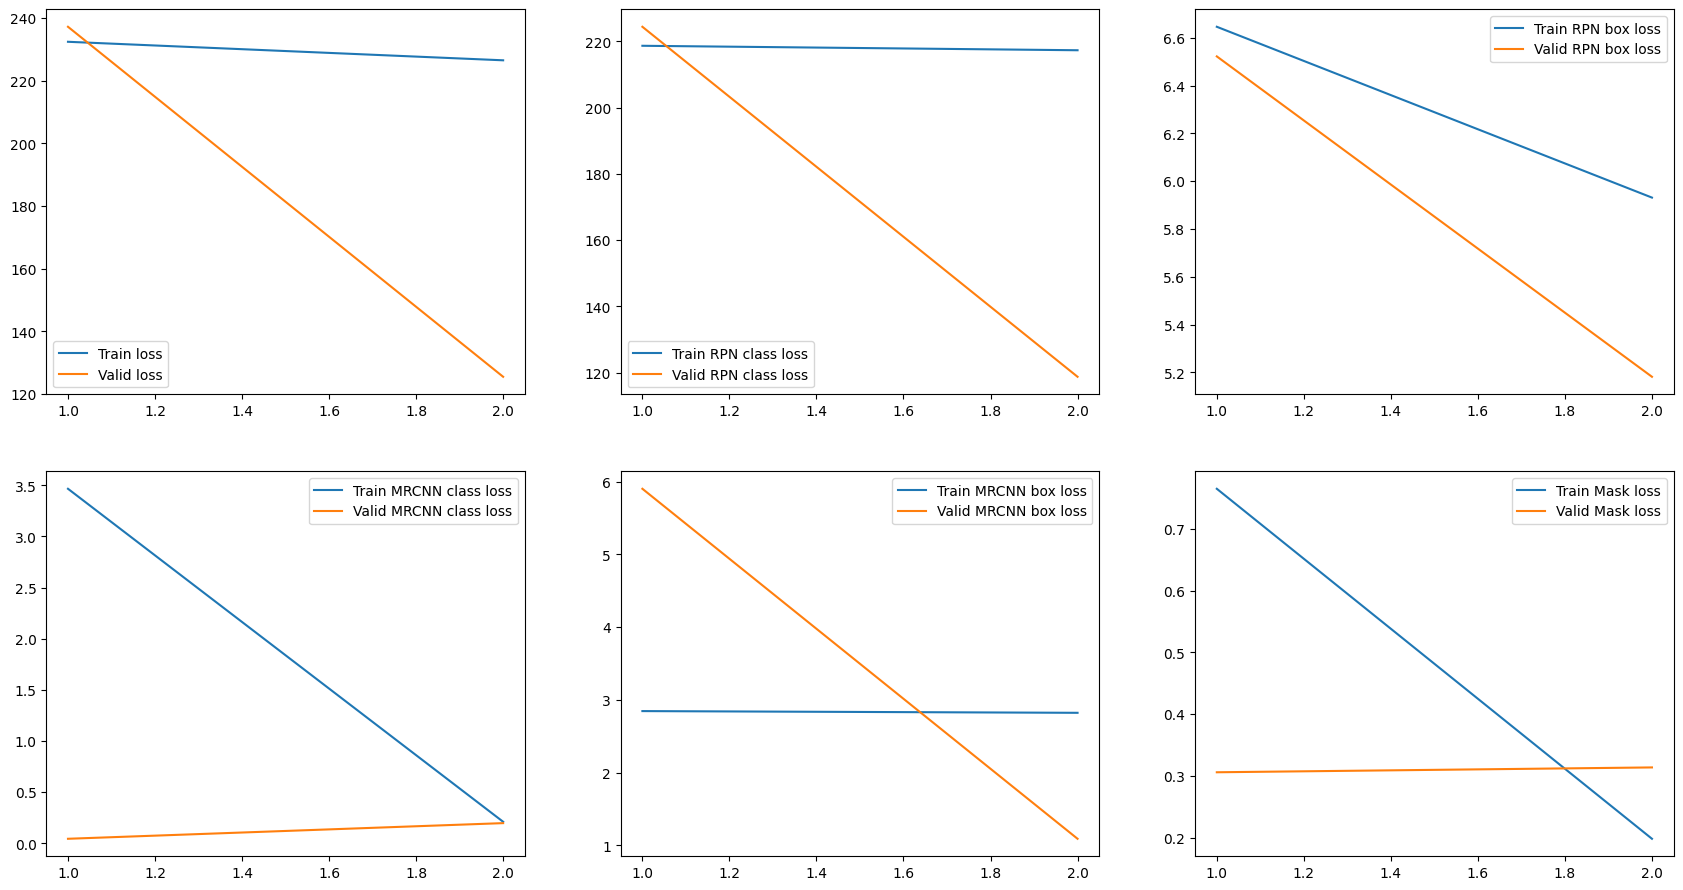

In [ ]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class loss")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class loss")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class loss")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class loss")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

Najbolja epoha (sa najmanjim validacionim gubitkom) i pripadajući gubitak su određeni pomoću Python funkcija `np.argmin(history["val_loss"])`
, a rezultati su prikazani u ispisu.

In [ ]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch:{best_epoch+1} val_loss:{score}')

Best Epoch:2 val_loss:125.51565551757812


In [ ]:
model_path ="/content/drive/MyDrive/initial20240121T1801/mask_rcnn_initial_0001.h5"


Instanca modela `MaskRCNN` se kreira u režimu *inference* koristeći konfiguraciju `InferenceConfig`, a težine modela se učitavaju iz prethodno treniranog modela.

In [ ]:
class InferenceConfig(ModelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir=main_dir)

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead


Loading weights from  /content/drive/MyDrive/initial20240121T1801/mask_rcnn_initial_0001.h5
Re-starting from epoch 1


Ova funkcija get_colors_for_class_ids dodeljuje određenu boju (.941, .204, .204) za svaki identifikator klase iz liste `class_ids`.

In [ ]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

Prikazivanje nekoliko primera poređenja između stvarnih oznaka i predikcija na validacionom skupu podataka:

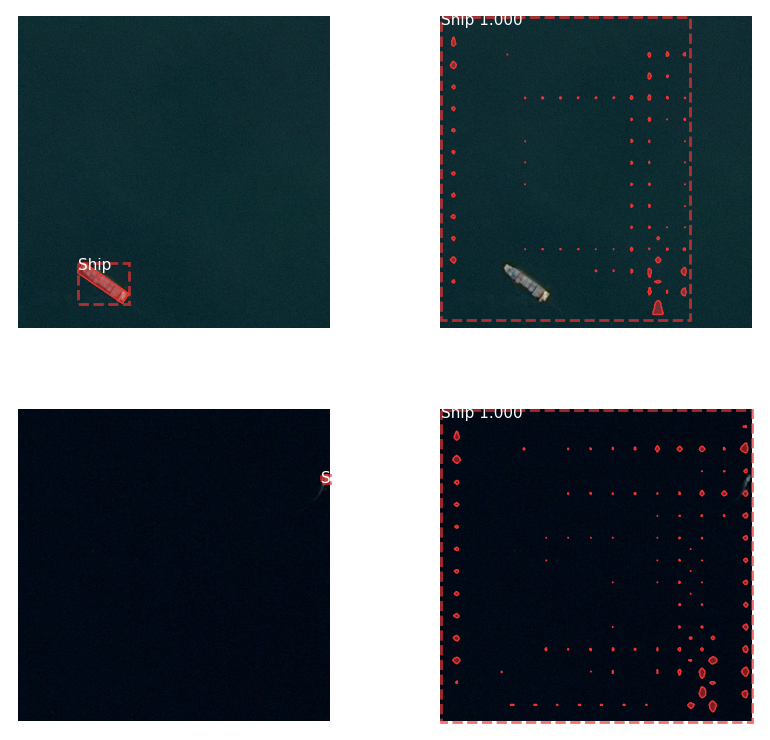

In [ ]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(4,6,1):

    image_id = random.choice(dataset.image_ids)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])

    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image])
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'],
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

**Metrike modela**

Ispod prikazana funkcija se koristi za evaluaciju performansi modela na validacionom skupu podataka i pruža informacije o preciznosti (AP) po klasi, srednjoj preciznosti po svim klasama (mAP), preseku nad unijom (IoU) po slici, srednjoj vrednosti IoU (isključujući NaN vrednosti), i Kaggle F2 oceni po slici i srednjoj vrednosti Kaggle F2 ocene.

In [ ]:
import numpy as np

# Define a function to calculate AP, mAP, IoU, and Kaggle F2 score
def calculate_ap_map_iou_f2(model, dataset, inference_config):
    APs = []
    IoUs = []
    F2s = []
    gt_bbox_list = []
    gt_class_id_list = []
    gt_mask_list = []
    pred_bbox_list = []
    pred_class_id_list = []
    pred_score_list = []

    # Loop through the dataset
    for image_id in dataset.image_ids:
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset, inference_config, image_id, use_mini_mask=False)

        # Append ground truth annotations to lists
        gt_bbox_list.append(gt_bbox)
        gt_class_id_list.append(gt_class_id)
        gt_mask_list.append(gt_mask)

        # Run inference on the image
        results = model.detect([original_image])
        r = results[0]

        # Append predicted results to lists
        pred_bbox = r['rois']
        pred_class_ids = r['class_ids']
        pred_scores = r['scores']
        pred_masks = r['masks']
        pred_bbox_list.append(pred_bbox)
        pred_class_id_list.append(pred_class_ids)
        pred_score_list.append(pred_scores)

        # Compute AP and IoU for the image
        AP, _, _, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, pred_bbox, pred_class_ids, pred_scores, pred_masks, iou_threshold=0.5)  # Use IoU threshold of 0.5 for competition evaluation
        APs.append(AP)

        # Calculate IoU
        valid_overlaps = overlaps[~np.isnan(overlaps)]  # Exclude NaN IoU values
        if len(valid_overlaps) > 0:
            IoU = np.mean(valid_overlaps)
            IoUs.append(IoU)

        # Calculate Kaggle F2 score
        TP = len(overlaps) - np.isnan(overlaps).sum()  # True Positives (excluding NaN IoU values)
        FN = len(gt_bbox) - TP  # False Negatives
        FP = len(pred_bbox) - TP  # False Positives
        beta = 2  # F2 score weight for recall (increase weight of recall)
        F2 = ((1 + beta*2) * TP) / ((1 + beta*2) * TP + beta*2 * FN + FP)  # Modified Kaggle F2 score formula
        F2s.append(F2)

    # Calculate mean Average Precision (mAP), mean IoU (excluding NaN values), and mean Kaggle F2 score
    mAP = np.mean(APs)
    mean_IoU = np.nanmean(IoUs) if len(IoUs) > 0 else np.nan
    mean_F2 = np.mean(F2s)

    return APs, mAP, IoUs, mean_IoU, F2s, mean_F2

# Call the function to calculate AP, mAP, IoU, and Kaggle F2 score
APs, mAP, IoUs, mean_IoU, F2s, mean_F2 = calculate_ap_map_iou_f2(model, dataset_val, inference_config)

# Print the results
print("Average Precision (AP) per class:")
for i, AP in enumerate(APs):
    print(f"Class {i}: AP = {AP}")

print("Mean Average Precision (mAP):", mAP)

print("Intersection over Union (IoU) per image:")
for i, IoU in enumerate(IoUs):
    print(f"Image {i}: IoU = {IoU}")

print("Mean IoU (excluding NaN values):", mean_IoU)

print("Kaggle F2 score per image:")
for i, F2 in enumerate(F2s):
    print(f"Image {i}: F2 score = {F2}")

print("Mean Kaggle F2 score:", mean_F2)

Average Precision (AP) per class:
Class 0: AP = 0.0
Class 1: AP = 0.0
Class 2: AP = 0.0
Class 3: AP = 0.0
Class 4: AP = 0.0
Class 5: AP = 0.0
Class 6: AP = 0.0
Class 7: AP = 0.0
Class 8: AP = 0.0
Class 9: AP = 0.0
Class 10: AP = 0.0
Class 11: AP = 0.0
Class 12: AP = 0.0
Class 13: AP = 0.0
Class 14: AP = 0.0
Class 15: AP = 0.0
Class 16: AP = 0.0
Class 17: AP = 0.0
Class 18: AP = 0.0
Class 19: AP = 0.0
Class 20: AP = 0.0
Class 21: AP = 0.0
Class 22: AP = 0.0
Class 23: AP = 0.0
Mean Average Precision (mAP): 0.0
Intersection over Union (IoU) per image:
Image 0: IoU = 0.021936459466814995
Image 1: IoU = 0.0
Image 2: IoU = 0.0010278214467689395
Image 3: IoU = 0.0
Image 4: IoU = 0.0
Image 5: IoU = 0.0
Image 6: IoU = 0.0
Image 7: IoU = 0.0021648965775966644
Image 8: IoU = 0.002107764594256878
Image 9: IoU = 0.0
Image 10: IoU = 0.0
Image 11: IoU = 0.0
Image 12: IoU = 0.0
Image 13: IoU = 0.0
Image 14: IoU = 0.0
Image 15: IoU = 0.0
Image 16: IoU = 0.002352941082790494
Image 17: IoU = 0.0072398190

**Zaključak**

U zaključku, može se istaći da je Mask R-CNN pokazao svoju izvanrednu efikasnost i popularnost kao algoritam za detekciju objekata, uspešno kombinujući prednosti detekcije objekata i segmentacije. Njegova sposobnost generisanja preciznih maski piksela za svaki detektovani objekat čini ga posebno korisnim u različitim aplikacijama baziranim na računarskoj viziji.

U poređenju sa drugim algoritmima za detekciju objekata, Mask R-CNN se ističe po sposobnosti pružanja detaljnih informacija i preciznih rezultata. Za razliku od starijih modela poput RCNN-a, Mask R-CNN donosi unapređenja u detekciji i interpretaciji rezultata. U poređenju sa Fast-RCNN-om, koji generiše samo okvire, Mask R-CNN pruža detaljnije informacije, dok se u odnosu na YOLO i SSD, koji takođe koriste okvire, Mask R-CNN izdvaja po sposobnosti prepoznavanja finih detalja kroz generisanje maski.

U ovom zadatku je sprovedena implementacija i treniranje Mask R-CNN modela za detekciju brodova na određenom dataset-u. Primena tehnike transfernog učenja i korišćenje prethodno obučenog modela doprineli su efikasnom treniranju na dataset-u za detekciju brodova. Vizualizacija rezultata detekcije pružila je uvid u preciznost lokalizacije i klasifikacije objekata, dok je analiza performansi kroz različite metrike poput AP, mAP, IoU i Kaggle F2 ocene pružila sveobuhvatan uvid u efikasnost modela.

Implementirane funkcionalnosti omogućavaju dalje istraživanje i prilagođavanje ovog modela za slične zadatke detekcije objekata u različitim oblastima.